# Mixture of 5 (Nested) circles
### Notebook

--- 

In [1]:
import Pkg, DrWatson
Pkg.activate("/storage/home/suv87/work/julia/ra-hmc")

  Activating project at `~/work/julia/ra-hmc`


In [2]:
using main
using Distributions, BenchmarkTools, Plots, Pipe, ProgressMeter
using Random, LinearAlgebra, Setfield, StatsBase
using Optim, Zygote, ForwardDiff

gr(fmt=:png, levels=5, lw=0.5, msa=0.1, msw=0.5, ma=0.2, msc=:firebrick1, legend=:topright)
ProgressMeter.ijulia_behavior(:clear);

---

## Model

$
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pA}[1]{\Big(#1\Big)}
\newcommand{\q}{\boldsymbol{q}}
\newcommand{\zerov}{\boldsymbol{0}}
\newcommand{\muv}{\boldsymbol{\mu}}
$

$$
\pi(\q) \propto \sum\limits_{i=1}^5 \phi\pA{\norm{\q - \muv_i}_p - r_i \  | \  \zerov, \sigma}
$$

where $\phi(\cdot | \mu, \sigma)$ is the PDF $\mathcal{N}(\zerov, \sigma^2)$

In [3]:
params = (; r1=4.0, r2=20.0, m=9.0, s=0.5, p=1)

(r1 = 4.0, r2 = 20.0, m = 9.0, s = 0.5, p = 1)

In [4]:
function make_model(d; r1=2.0, r2=16.0, m=8.0, s=0.25, p=2)
    σ = (s)^(d / 2)
    M = [[-m; zeros(d-1)], [zeros(d-1); -m], [0; zeros(d-1)], [zeros(d-1); m], [m; zeros(d-1)]]
    R = [r1; r1; r2; r1; r1]
    F(x) = sum([pdf(Normal(0.0, σ), norm(x .- m, p) - r) for (r, m) in zip(R, M)])
    f(x) = max(F(x), floatmin(Float64))
    U(x) = min(-log(f(x)), floatmax(Float64))
    mod = Model(
        ξ=MvNormal(d, 1.0),
        d=d,
        f=x -> f(x),
        g=x -> Zygote.gradient(x_ -> Zygote.forwarddiff(f, x_), x),
        U=x -> min(-log(f(x)), floatmax(Float64)),
        dU=x -> Zygote.gradient(x_ -> Zygote.forwarddiff(U, x_), x)[1],
    )
    return mod
end

function scatterplot(x; 
        baseplt=plot(0,0,label=""), 
        label="", ma=0.25, cb=false,
        c=cgrad(:viridis, 2, categorical=true), 
        kwargs...)
    
    plt_lim = (-params.r2, params.r2) .* 1.1
    
    if typeof(x) <: Tuple
        marker_size = exp.(2 .* standardize(UnitRangeTransform, x[2]))
        nrm = norm.(eachrow(x[1]), params.p)
        cl = map(x -> x < params.r2 - 4 * params.s ? 0.0 : 1.0, nrm)
        
        plt = plot(baseplt, x[1] |> m2t, c=:black, lw=0.1, la=0.2, label="", lim=plt_lim, ratio=1)
        plt = scatter(plt, x[1] |> m2t, ms=marker_size, marker_z = cl, ma=ma, label=label, cb=cb; kwargs...)
    else
        
        nrm = norm.(eachrow(x), params.p)
        cl = map(x -> x < params.r2 - 4 * params.s ? 0.0 : 1.0, nrm)
        
        plt = plot(baseplt, x |> m2t, c=:black, lw=0.1, la=0.2, label="", lim=plt_lim, ratio=1)
        plt = scatter(plt, x |> m2t, marker_z = cl, ma=ma, label=label, cb=cb; kwargs...)
    end
    return plt
end


function acfplot(x; kwargs...)
    if typeof(x) <: Tuple
        return plot(norm.(eachrow(x[1]), params.p); kwargs...)
    else
        return plot(norm.(eachrow(x), params.p); kwargs...)
    end
end


function sample_spheres(n, d; r1=2.0, r2=14.0, m=8.0, s=0.5, p=2)
    M = [[-m; zeros(d-1)], [zeros(d-1); -m], [0; zeros(d-1)], [zeros(d-1); m], [m; zeros(d-1)]]
    R = [r1; r1; r2; r1; r1]
    ind = sample(eachindex(R), weights(R.^(d-1)), n, replace=true)
    r = R[ind] .+ rand(Normal(0.0, s), n)
    M = M[ind] |> a2m
    X = randn(n, d)
    X = X ./ norm.(eachrow(X), p)
    return M .+ r .* X
end

function w2(X)
    if typeof(X) <: Tuple
        n, d = size(X[1])
        Z = sample_spheres(n, d; params...)
        return W2(X[1], Z, X[2] ./ sum(X[2]))
    else
        Z = sample_spheres(size(X)...; params...)
        return W2(X, Z)
    end
end

w2 (generic function with 1 method)

In [5]:
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)
gr(levels=20, lw=0.5, msa=0.1, msw=0.5, ma=0.2, msc=:firebrick1, legend=:topright)
ProgressMeter.ijulia_behavior(:clear);

plt(; lim=(-22, 22), kwargs...) = contourf(
    repeat([range(lim..., length=200)], 2)...,
    (x, y) -> model.f([x, y]),
    c=cls
    ; kwargs...
)

plt (generic function with 1 method)

---

# $d = 2$

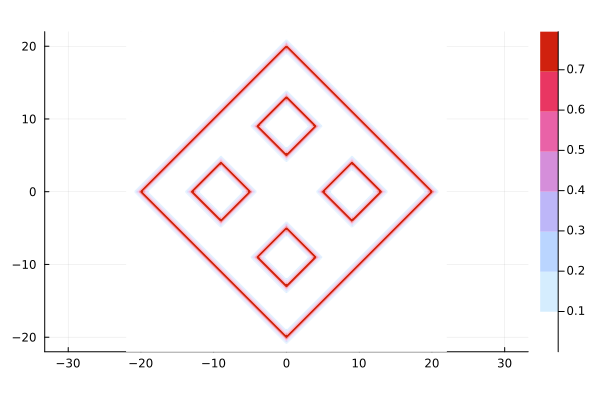

In [6]:
model = make_model(2; params...);
plt(ratio=1, levels=7)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
  HMC(0.420513058951008, 12, Any[]):  0.9034193161367726


Acceptance Ratio = 0.9034
 25.596346 seconds (28.35 M allocations: 1.499 GiB, 1.79% gc time, 95.00% compilation time: 0% of which was recompilation)


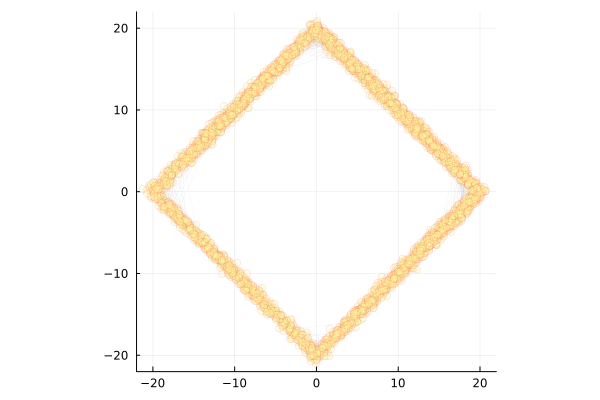

In [7]:
@time s1, a1 = mcmc(
    DualAverage(λ=5.0, δ=0.65),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_hmc = s1[a1, :];
x_hmc |> scatterplot

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
  RAHMC(0.2037479992479655, 61, 0.3137827013412907, Any[]):  0.47290541891621674


Acceptance Ratio = 0.4729
 12.798895 seconds (52.71 M allocations: 3.104 GiB, 6.49% gc time, 9.49% compilation time)


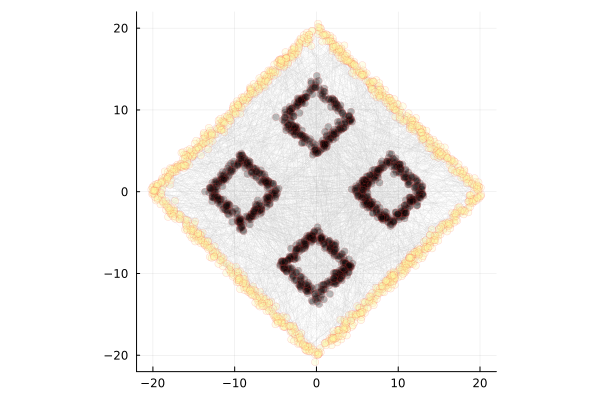

In [8]:
@time s2, a2 = mcmc(
    DualAverage(λ=12.5, δ=0.65),
    RAHMC(),
    model; n=5e3, n_burn=1e3
)
x_rahmc = s2[a2, :];
x_rahmc |> scatterplot

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  RAM(ZeroMeanIsoNormal(
dim: 2
μ: Zeros(2)
Σ: [4.0 0.0; 0.0 4.0]
)
, [-0.6205093768492543, 0.2545626087215049], Any[]):       0.46275620729878353


Acceptance Ratio = 0.4652
  1.439177 seconds (2.71 M allocations: 154.744 MiB, 3.35% gc time, 88.95% compilation time)


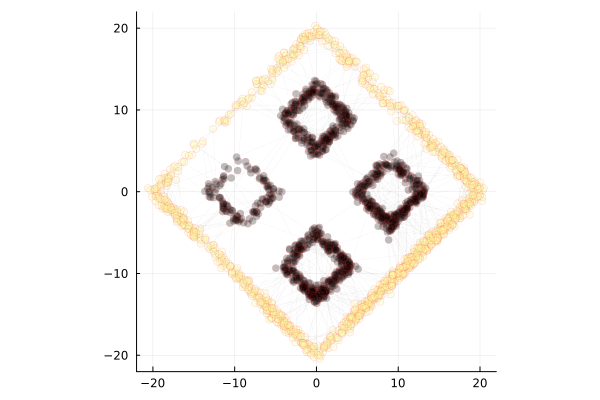

In [9]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 2.0), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_ram = s3[a3, :];
x_ram |> scatterplot

Progress: 100%|█████████████████████████████████████████| Time: 0:02:29
  PEHMC:  0.5033112582781457


Acceptance Ratio = 0.5
149.794399 seconds (838.43 M allocations: 31.851 GiB, 5.62% gc time, 14.13% compilation time)


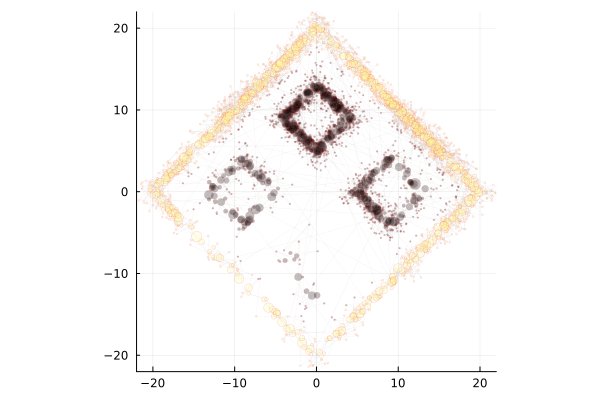

In [10]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.12, L=20, N=100),
    model; n=5e1, n_burn=1e2
)
x_pehmc, w_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...];
scatterplot((x_pehmc, w_pehmc))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
  WHMC:  0.9196321471411435


Acceptance Ratio = 0.9196
 24.002886 seconds (69.41 M allocations: 3.225 GiB, 4.06% gc time, 59.45% compilation time: 2% of which was recompilation)


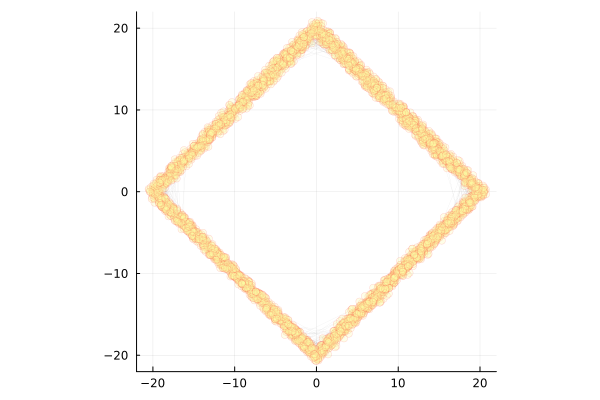

In [11]:
whmc_opt = WHMCOpt(method=LBFGS(), max_iter=10_000, temp=1.2)

@time s5, a5 = mcmc(
    WHMC(opt=whmc_opt, ϵ=0.5, L=10, k=1_000),
    model,
    n = 5e3, n_burn=1e3
)
x_whmc = s5[a5, :];
x_whmc |> scatterplot

In [12]:
var_names = ["hmc", "rahmc", "ram", "pehmc", "whmc"]
xs2d = [x_hmc, x_rahmc, x_ram, (x_pehmc, w_pehmc), x_whmc]
names = ["HMC" "RA-HMC" "RAM" "PEHMC" "WHMC"];

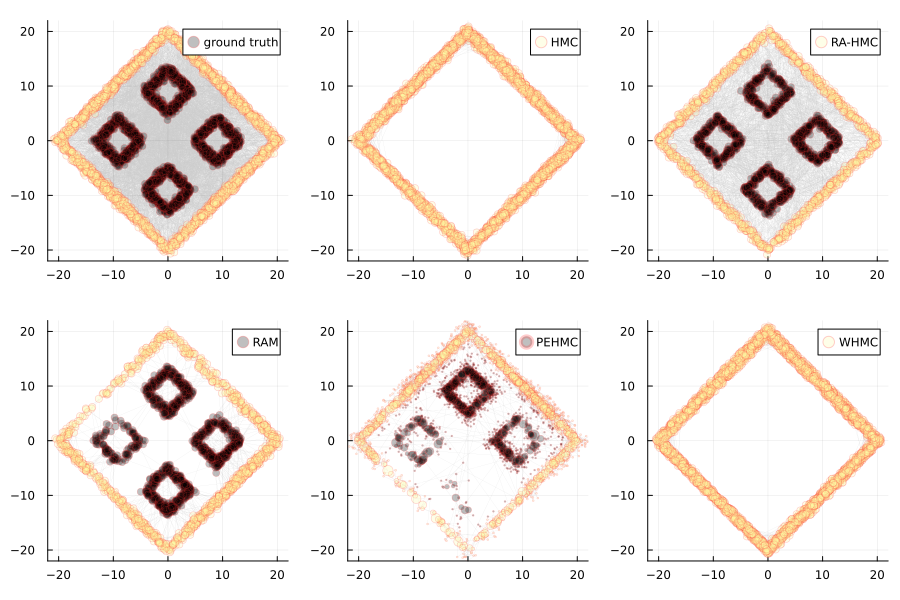

In [13]:
plot(
    scatterplot(sample_spheres(5000, 2; params...), label="ground truth", p=params.p), 
    (@pipe zip(xs2d, names) .|> scatterplot(_[1], label=_[2], p=params.p))...,
    cb=false, layout=(2, 3), size=(900, 600)
)

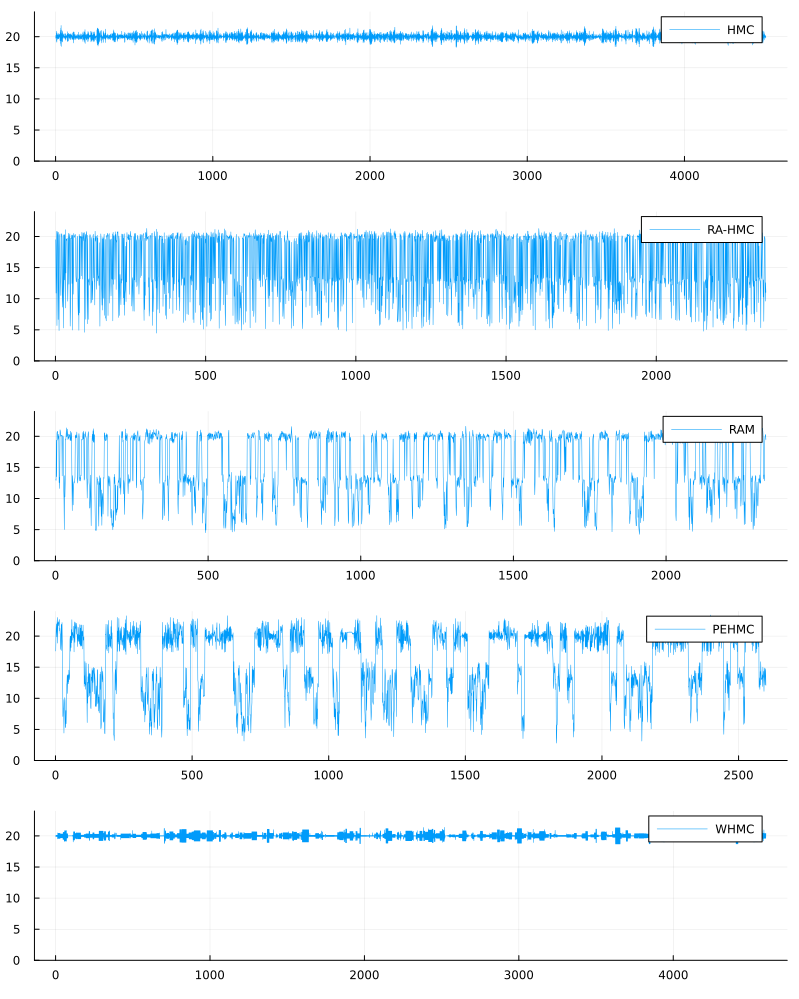

In [14]:
lims = (0.0, 1.2) .* params.r2
plot(
    (@pipe zip(xs2d, names) .|> acfplot(_[1], label=_[2]))..., 
    layout=(5, 1), size=(800, 1000), ylim=lims
)

In [15]:
w2.(xs2d)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


5-element Vector{Float64}:
 14.088488535465753
  0.2717962596006548
  0.37196800329357715
  1.0361134556358602
 13.7415722796215

---

# $d = 3$


In [16]:
model = make_model(3; params...);

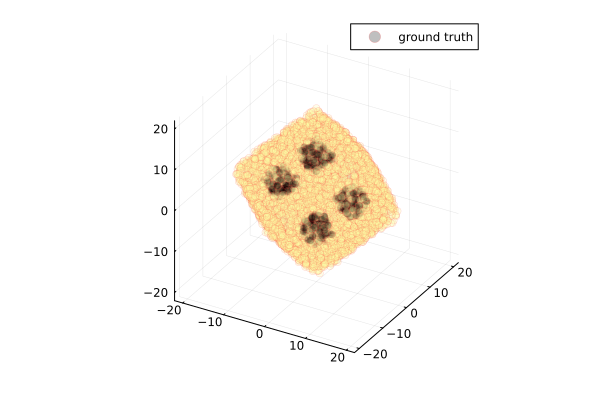

In [17]:
scatterplot(sample_spheres(10000, 3; params...), label="ground truth", p=params.p)

In [18]:
d3plot(x) = @pipe x |> plot(scatterplot(_), acfplot(_, label=""), layout=(1, 2), size=(700, 400))

d3plot (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
  HMC(0.1902717001836113, 289, Any[]):  0.6504699060187963


Acceptance Ratio = 0.6505
 24.018265 seconds (98.15 M allocations: 6.281 GiB, 6.86% gc time, 3.92% compilation time)


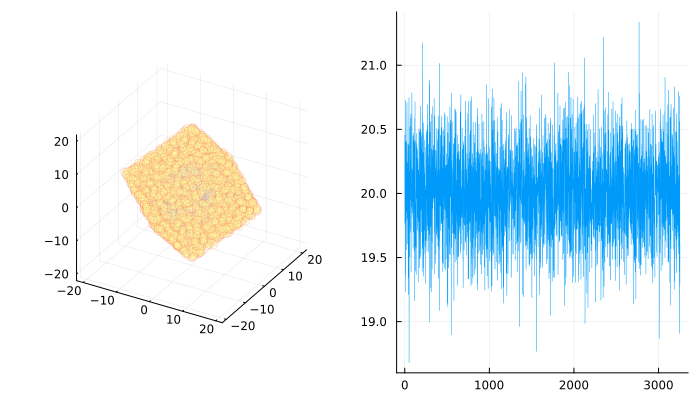

In [19]:
@time s1, a1 = mcmc(
    DualAverage(λ=55.0, δ=0.65),
    HMC(),
    model; n=5e3, n_burn=1e3
)
x_hmc_3d = s1[a1, :];
x_hmc_3d |> d3plot

Progress: 100%|█████████████████████████████████████████| Time: 0:03:56
  RAHMC(0.02416194007328, 1655, 0.08589557482635203, Any[]):  0.636872625474905


Acceptance Ratio = 0.6369
236.148681 seconds (1.08 G allocations: 68.440 GiB, 5.08% gc time)


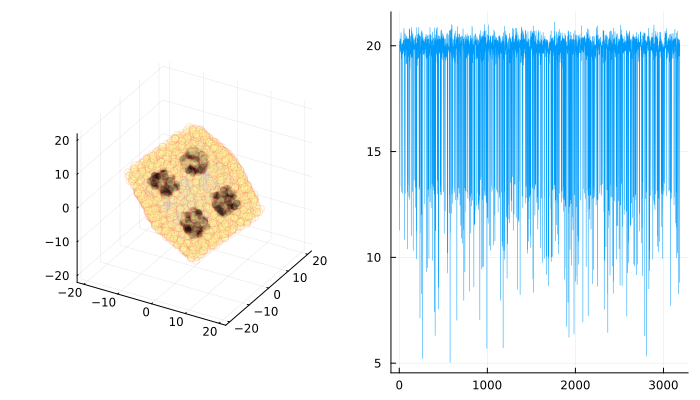

In [20]:
@time s2, a2 = mcmc(
    DualAverage(λ=40.0, δ=0.65),
    RAHMC(), 
    model; n=5e3, n_burn=1e3
)
x_rahmc_3d = s2[a2, :];
x_rahmc_3d |> d3plot

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(ZeroMeanIsoNormal(
dim: 3
μ: Zeros(3)
Σ: [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0]
)
, [-0.6881314214167662, -0.19341516751558763, -1.3803663661085797], Any[]):       0.32994500916513914


Acceptance Ratio = 0.3287
  0.125208 seconds (1.00 M allocations: 65.641 MiB)


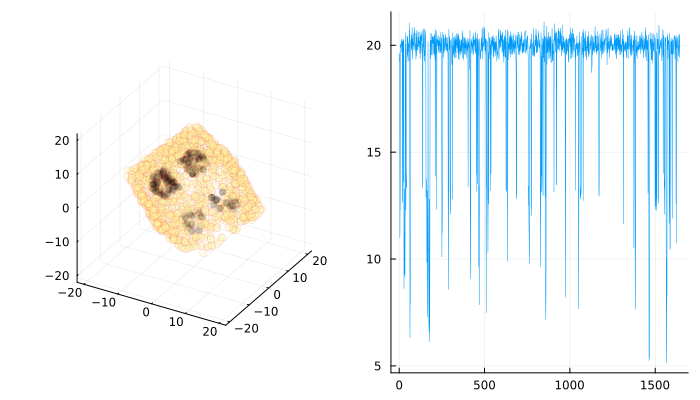

In [21]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 2.0), z=randn(model.d)),
    model; n=5e3, n_burn=1e3
)
x_ram_3d = s3[a3, :];
x_ram_3d |> d3plot

Progress: 100%|█████████████████████████████████████████| Time: 0:02:10
  PEHMC:  0.7483443708609272


Acceptance Ratio = 0.8077
130.009112 seconds (808.45 M allocations: 30.311 GiB, 5.86% gc time)


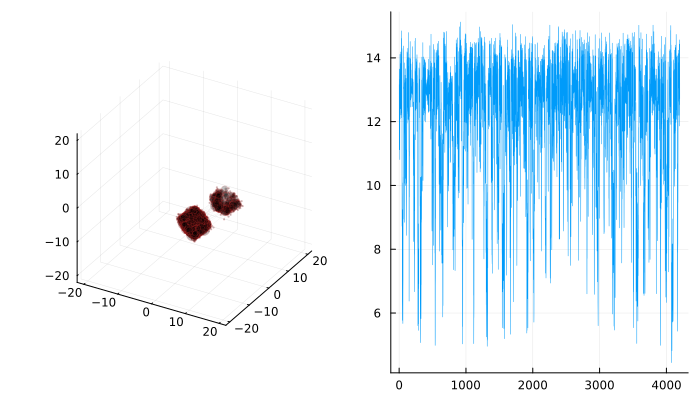

In [22]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.05, L=20, N=100),
    model; n = 5e1, n_burn=1e2
)

x_pehmc_3d, w_pehmc_3d = [s4[a4, :]...] |> a2m, [w4[a4, :]...];
(x_pehmc_3d, w_pehmc_3d) |> d3plot

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
  WHMC:  0.7902838864454218


Acceptance Ratio = 0.7903
 24.023393 seconds (103.86 M allocations: 4.880 GiB, 4.94% gc time)


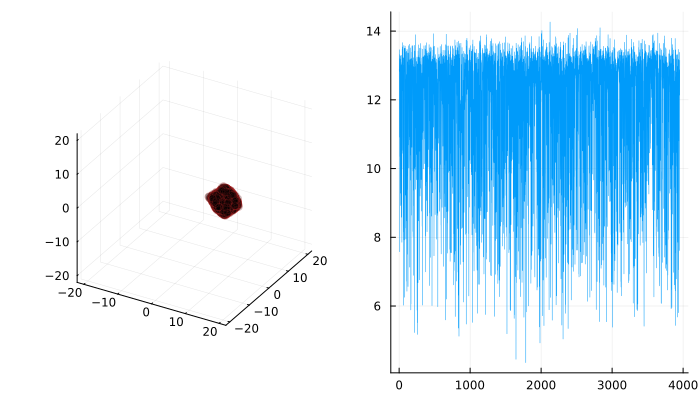

In [24]:
@time s5, a5 = mcmc(
    WHMC(opt=whmc_opt, ϵ=0.175, L=25),
    model; n = 5e3, n_burn=1e3
)
x_whmc_3d = s5[a5, :];
@pipe x_whmc_3d |> plot(scatterplot(_, p=params.p), plot(norm.(eachrow(_), params.p), label=""), layout=(1, 2), size=(700, 400))

In [25]:
xs3d = [x_hmc_3d, x_rahmc_3d, x_ram_3d, (x_pehmc_3d, w_pehmc_3d), x_whmc_3d];

In [26]:
w2.(xs3d)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


5-element Vector{Float64}:
  3.868068636054704
  1.1586650426313883
  2.08871271607057
 64.0295006123467
 97.86269855922944

---